In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from PIL import Image


2023-12-08 11:39:07.287692: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-08 11:39:07.638850: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-08 11:39:07.640765: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-08 11:39:09.043234: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def load_images_from_folder(folder_path):
    images = []
    labels = []
    
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        if os.path.isfile(img_path):
            img = Image.open(img_path)
            images.append(np.array(img))
            labels.append(os.path.basename(folder_path))
    
    return images, labels

def create_dataset(root_folder):
    all_image_paths = []
    all_labels = []

    for folder_name in os.listdir(root_folder):
        folder_path = os.path.join(root_folder, folder_name)
        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                img_path = os.path.join(folder_path, filename)
                if os.path.isfile(img_path):
                    all_image_paths.append(img_path)
                    all_labels.append(folder_name)

    data = {"Image Path": all_image_paths, "Label": all_labels}
    df = pd.DataFrame(data)

    return df

root_folder = "/home/kakas/Desktop/feetKaggle/Photos/"
df = create_dataset(root_folder)

In [3]:
balanced_df = pd.DataFrame(columns=df.columns)

# Randomly sample min_count images for each category
for label in df['Label'].unique():
    category_subset = df[df['Label'] == label]
    balanced_subset = category_subset.sample(n=1520, random_state=42)  # You can use any random_state for reproducibility
    balanced_df = balanced_df.append(balanced_subset, ignore_index=True)

/tmp/ipykernel_9610/606974162.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  balanced_df = balanced_df.append(balanced_subset, ignore_index=True)


In [4]:
df = balanced_df

In [5]:
df = shuffle(df, random_state=42)

In [6]:
df

,Image Path,Label
471,/home/kakas/Desktop/feetKaggle/Photos/greek/19...,greek
2646,/home/kakas/Desktop/feetKaggle/Photos/roman/34...,roman
23,/home/kakas/Desktop/feetKaggle/Photos/greek/91...,greek
3477,/home/kakas/Desktop/feetKaggle/Photos/egyptian...,egyptian
135,/home/kakas/Desktop/feetKaggle/Photos/greek/46...,greek
...,...,...
4426,/home/kakas/Desktop/feetKaggle/Photos/egyptian...,egyptian
466,/home/kakas/Desktop/feetKaggle/Photos/greek/44...,greek
3092,/home/kakas/Desktop/feetKaggle/Photos/egyptian...,egyptian
3772,/home/kakas/Desktop/feetKaggle/Photos/egyptian...,egyptian


In [7]:
def load_images_from_dataset(dataset, target_size=(160, 160)):
    images = []
    labels = []
    label_encoder = LabelEncoder()
    dataset['Numerical Label'] = label_encoder.fit_transform(dataset['Label'])  #1: greek, 2: roman, 0: egyptian
    train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)

    for index, row in train_set.iterrows():
        img_path = row['Image Path']
        numerical_label = row['Numerical Label']
        img = Image.open(img_path)
        img = img.resize(target_size)
        img_array = np.array(img)

        images.append(img)
        labels.append(numerical_label)

    test_images = []
    test_labels = []
    for index, row in test_set.iterrows():
        img_path = row['Image Path']
        numerical_label = row['Numerical Label']
        img = Image.open(img_path)
        img = img.resize(target_size)
        img_array = np.array(img)

        test_images.append(img)
        test_labels.append(numerical_label)

    return images, labels, test_images, test_labels

In [8]:
train_images, train_labels, test_images, test_labels = load_images_from_dataset(df)

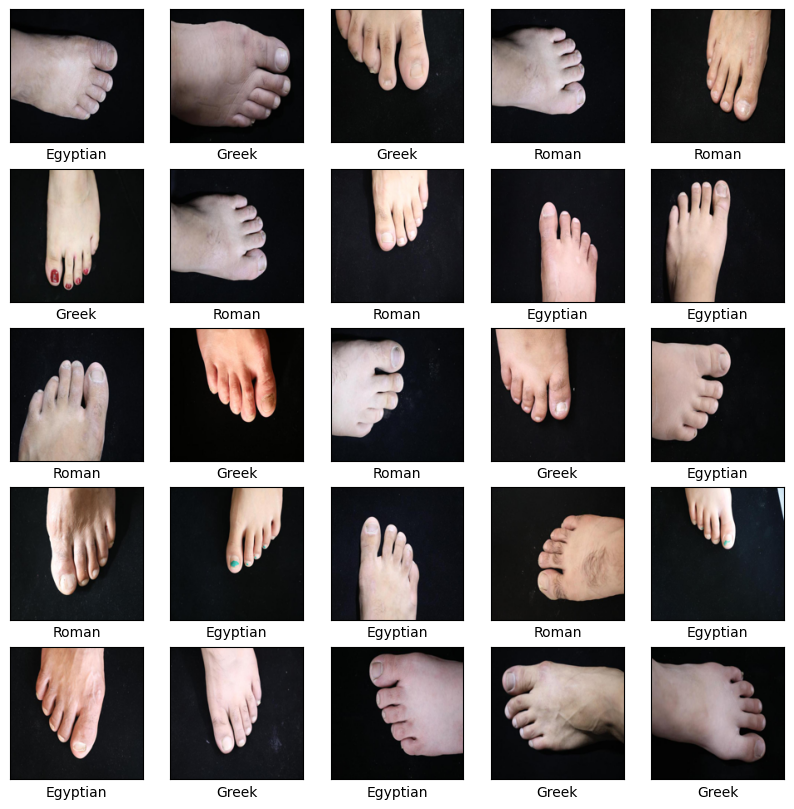

In [9]:
class_names = ['Egyptian', 'Greek', 'Roman']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [10]:
train_images[0].size

(160, 160)

In [11]:
train_images = np.array([np.array(img) for img in train_images])
test_images = np.array([np.array(img) for img in test_images])

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [12]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(160, 160, 3),
                                               include_top=False,
                                               weights='imagenet')

In [13]:
base_model.trainable = False


In [14]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)


In [15]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(160, 160, 3)),
    rescale,
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3)
])

In [16]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

In [17]:
history = model.fit(train_images, train_labels, epochs=5)

Epoch 1/5


2023-12-08 11:41:34.203592: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 280166400 exceeds 10% of free system memory.
2023-12-08 11:41:37.458118: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 26214400 exceeds 10% of free system memory.
2023-12-08 11:41:37.511715: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 26214400 exceeds 10% of free system memory.
2023-12-08 11:41:37.530222: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 26214400 exceeds 10% of free system memory.
2023-12-08 11:41:37.550061: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 78643200 exceeds 10% of free system memory.


114/114 [==============================] - 36s 291ms/step - loss: 0.6619 - accuracy: 0.3434
Epoch 2/5
114/114 [==============================] - 32s 282ms/step - loss: 0.0018 - accuracy: 0.3615
Epoch 3/5
114/114 [==============================] - 32s 283ms/step - loss: 7.2573e-04 - accuracy: 0.3593
Epoch 4/5
114/114 [==============================] - 32s 283ms/step - loss: 3.9189e-04 - accuracy: 0.3607
Epoch 5/5
114/114 [==============================] - 33s 286ms/step - loss: 3.0925e-04 - accuracy: 0.3592


In [54]:
def ev_plt(history):
    acc = history.history['accuracy']
    #val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    #val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(loss, label='Training Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')


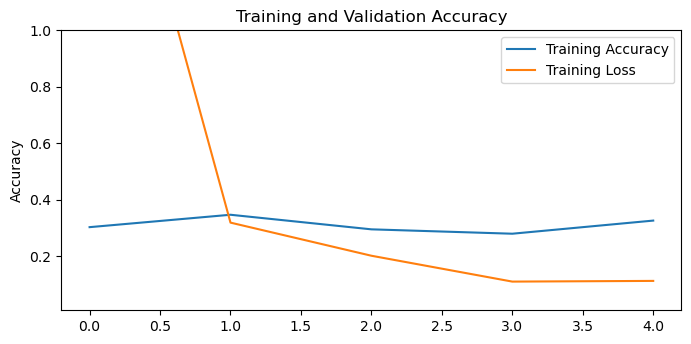

In [70]:
ev_plt(history)

In [18]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

29/29 - 9s - loss: 0.0044 - accuracy: 0.3494 - 9s/epoch - 315ms/step

Test accuracy: 0.34941521286964417


In [19]:
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])

In [20]:
predictions = probability_model.predict(test_images)

29/29 [==============================] - 11s 314ms/step


In [21]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)
  
def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(3))
  plt.yticks([])
  thisplot = plt.bar(range(3), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

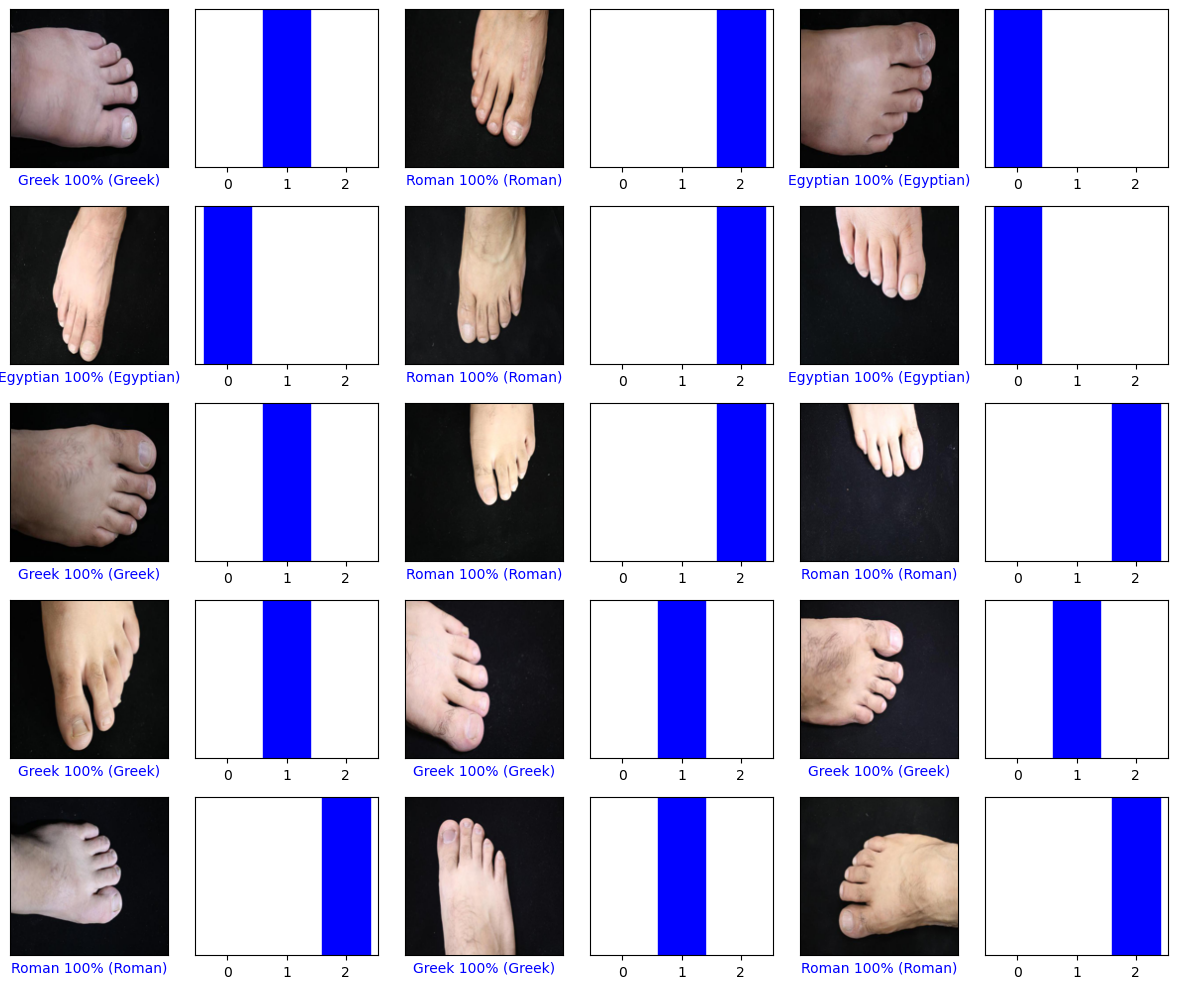

In [22]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()